In [1]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Change these variables based on our car.
wheelbase = 2.6
n = 16

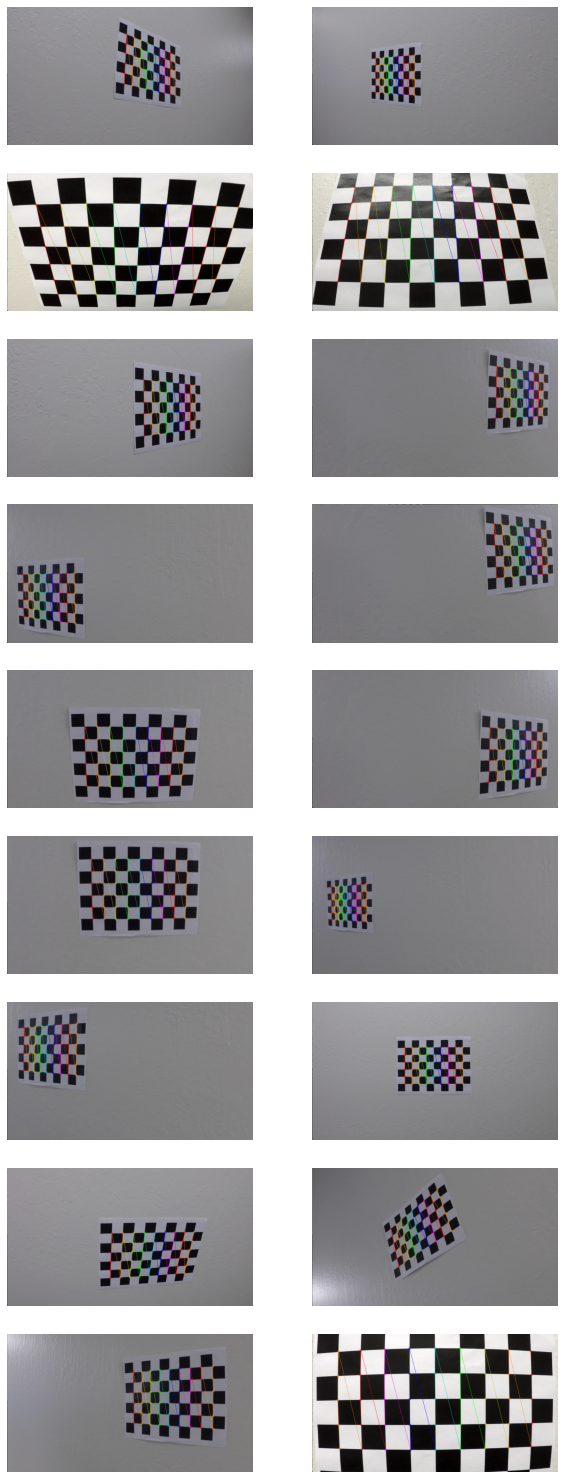

In [3]:
from utils import cameraCalibration
(ret, cameraMat, distCoeffs, rvecs, tvecs), fig = cameraCalibration.get_calibration_matrix(os.path.join('camera_cal','*.jpg'))
fig.set_size_inches(10,30)

([], [])

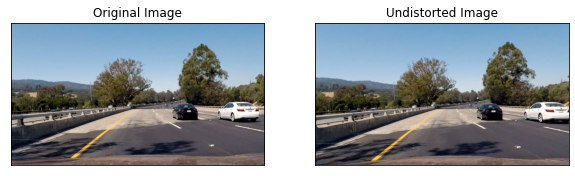

In [4]:
test_image = plt.imread(os.path.join('test_images', 'test4.jpg'))
undistorted_img = cameraCalibration.undistort(test_image, cameraMat, distCoeffs)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

Text(0.5, 1.0, 'Thresholded Binary')

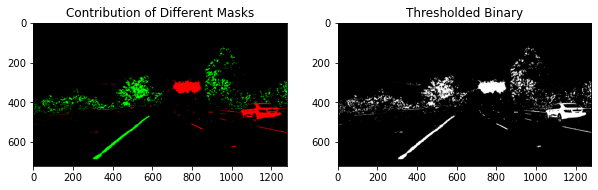

In [5]:
from utils.thresholding import *

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
thresholded = threshold(test_image, color=True)
plt.imshow(thresholded)
plt.title('Contribution of Different Masks')

plt.subplot(1,2,2)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

Text(0.5, 1.0, 'Binary Warped Image')

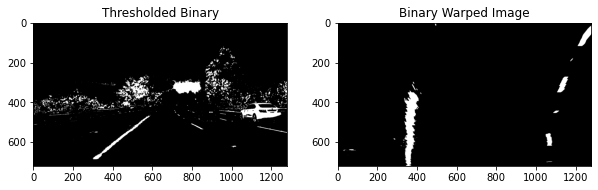

In [6]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
offset = 200
src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   673 ],
    [  153 ,   673 ]])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

Text(0.5, 1.0, 'Lane Detected')

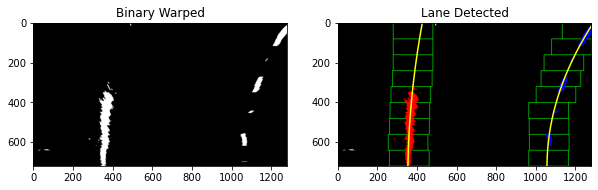

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

In [13]:
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

is_left_turn = y2 < 0
curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 1341.489640


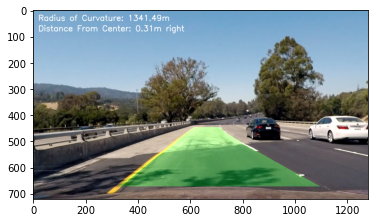

In [9]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.imshow(result)

In [14]:
import math

def calculate_turn_angle(radius_of_curvature, wheelbase, steering_ratio, is_left_turn):
    if radius_of_curvature == 0:
        return 0
    turn_angle = steering_ratio * math.asin(wheelbase/radius_of_curvature)
    
    if is_left_turn:
        turn_angle = -turn_angle
        
    return turn_angle

angle = calculate_turn_angle(curvature, wheelbase, n, is_left_turn)
print(angle)

0.031010322264273846
